In [3]:
from aum import DatasetWithIndex
from sklearn.preprocessing import MinMaxScaler
from math import pi
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.mixture import GaussianMixture
from copy import deepcopy
import torch.optim as optim
import torch.nn as nn
import torch
import pandas as pd
import numpy as np
import umap
import logging

import sys
sys.path.insert(0, "../")

In [4]:
from src.utils.data_loader import *
from src.models.neuralnets import *
from src.utils.utils import *
from data_iq.dataiq_class import *

In [5]:
dataset = "prostate"

(
    train_loader,
    train_data,
    X_train,
    y_train,
    X_test,
    y_test,
    X_train_pd,
    y_train_pd,
    X_test_pd,
    y_test_pd,
    nlabels,
    corr_vals,
    column_ids,
    df,
) = load_dataset(dataset=dataset)

# Train model and compute Data-IQ after each epoch

In [7]:
input_size = X_train.shape[1]
nlabels = len(np.unique(y_train))
BATCH_SIZE = 128
LEARNING_RATE = 0.001
EPOCHS = 10

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

dataiq_list = []
checkpoint_list = []
ckpt_nets = []

train_loader = DataLoader(
    dataset=DatasetWithIndex(train_data), batch_size=BATCH_SIZE, shuffle=True
)

net = Net1(input_size=input_size, nlabels=nlabels)
net.to(device)
criterion = torch.nn.NLLLoss()

optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

# Initialize Data-IQ
dataiq = DataIQ_Torch(X=X_train, y=y_train, sparse_labels=True)

logging.info("Training base model")
for e in range(1, EPOCHS + 1):
    net.train()
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch, sample_ids in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        sf = nn.LogSoftmax()
        y_pred = net(X_batch)
        _, predicted = torch.max(y_pred.data, 1)

        y_batch = y_batch.to(torch.int64)

        loss = criterion(sf(y_pred), y_batch)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += (predicted == y_batch).sum().item() / len(y_batch)

    # log the checkpoint to Data-IQ
    dataiq.on_epoch_end(net, device=device)
    print(
        f"Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}"
    )
    # save checkpoints
    ckpt_nets.append(deepcopy(net))

checkpoint_list.append(ckpt_nets)
dataiq_list.append(dataiq)

/content/src/models/neuralnets.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  X = F.softmax(self.output(X))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Epoch 001: | Loss: 0.56124 | Acc: 0.766
Epoch 002: | Loss: 0.53754 | Acc: 0.769
Epoch 003: | Loss: 0.52452 | Acc: 0.780
Epoch 004: | Loss: 0.49503 | Acc: 0.813
Epoch 005: | Loss: 0.48371 | Acc: 0.823
Epoch 006: | Loss: 0.48028 | Acc: 0.826
Epoch 007: | Loss: 0.47524 | Acc: 0.833
Epoch 008: | Loss: 0.47610 | Acc: 0.831
Epoch 009: | Loss: 0.47301 | Acc: 0.835
Epoch 010: | Loss: 0.47663 | Acc: 0.830


# Extract an intermediate layer to embed

In [8]:
# GET TRAINING EMBEDDINGS
mymodel = checkpoint_list[0][9]
layer = "dense3"

# TRAIN
logging.info("Getting training embeddings")
activation = {}


def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()

    return hook


mymodel.dense3.register_forward_hook(get_activation(layer))
output = mymodel(torch.tensor(X_train, device=device))
intermediate_train = activation[layer].cpu().numpy()

# GET TESTING EMBEDDINGS
logging.info("Getting testing embeddings")
# TEST
activation = {}
mymodel.dense3.register_forward_hook(get_activation(layer))

try:
    output = mymodel(torch.tensor(X_test.to_numpy().astype(np.float32), device=device))
    intermediate_test = activation[layer].cpu().numpy()
except:
    output = mymodel(torch.tensor(X_test.astype(np.float32), device=device))
    intermediate_test = activation[layer].cpu()

# Compute DATA-IQ Groups

In [9]:
logging.info("Getting Data-IQ subgroups")
d_idx = 0
aleatoric_train = dataiq_list[d_idx].aleatoric
confidence_train = dataiq_list[d_idx].confidence

percentile_thresh = 50
conf_thresh = 0.5
conf_thresh_low = 0.25
conf_thresh_high = 0.75

hard_train = np.where(
    (confidence_train <= conf_thresh_low)
    & (aleatoric_train <= np.percentile(aleatoric_train, percentile_thresh))
)[0]
easy_train = np.where(
    (confidence_train >= conf_thresh_high)
    & (aleatoric_train <= np.percentile(aleatoric_train, percentile_thresh))
)[0]

hard_easy = np.concatenate((hard_train, easy_train))
ambig_train = []
for id in range(len(confidence_train)):
    if id not in hard_easy:
        ambig_train.append(id)
ambig_train = np.array(ambig_train)

logging.info("Train :", len(hard_train), len(ambig_train), len(easy_train))

# Embed using UMAP for easy, ambiguous and hard

In [10]:
logging.info("UMAP easy...")
mapper = umap.UMAP().fit(intermediate_train[easy_train, :], y=y_train[easy_train])
embedding_train_easy = mapper.transform(intermediate_train[easy_train, :])

logging.info("UMAP Embed ambig...")
mapper = umap.UMAP().fit(intermediate_train[ambig_train, :], y=y_train[ambig_train])
embedding_train_ambig = mapper.transform(intermediate_train[ambig_train, :])

logging.info("UMAP Embed hard...")
mapper = umap.UMAP().fit(intermediate_train[hard_train, :], y=y_train[hard_train])
embedding_train_hard = mapper.transform(intermediate_train[hard_train, :])

# Get the actual values for each group

In [11]:
compare_dict = {}
xdata = X_train_pd
xdata["mortality"] = y_train
mean_vals = np.mean(xdata.iloc[:, :])
n_samples = len(xdata.iloc[:, :])
compare_dict["overall"] = mean_vals.append(pd.Series([n_samples], index=["n_samples"]))

mean_vals = np.mean(xdata.iloc[easy_train, :])
n_samples = len(xdata.iloc[easy_train, :])
compare_dict["easy"] = mean_vals.append(pd.Series([n_samples], index=["n_samples"]))

mean_vals = np.mean(xdata.iloc[ambig_train, :])
n_samples = len(xdata.iloc[ambig_train, :])
compare_dict["ambig"] = mean_vals.append(pd.Series([n_samples], index=["n_samples"]))

mean_vals = np.mean(xdata.iloc[hard_train, :])
n_samples = len(xdata.iloc[hard_train, :])
compare_dict["hard"] = mean_vals.append(pd.Series([n_samples], index=["n_samples"]))

pd.DataFrame(compare_dict)

,overall,easy,ambig,hard
age,68.946065,67.374594,70.154360,71.692675
psa,25.915961,24.799675,27.158790,23.099045
comorbidities,0.360387,0.413691,0.294080,0.581210
treatment_CM,0.108194,0.132392,0.076024,0.234076
treatment_Primary hormone therapy,0.427032,0.201129,0.648388,0.230892
treatment_Radical Therapy-RDx,0.392645,0.568102,0.229228,0.439490
treatment_Radical therapy-Sx,0.072129,0.098377,0.046359,0.095541
grade,2.562194,2.377276,2.726210,2.614650
stage_1,0.110129,0.119548,0.102607,0.097134
stage_2,0.589871,0.604658,0.573263,0.628981


# For each subset fit a GMM to get clusters then add to radial diagram

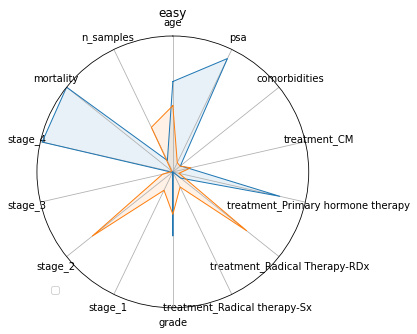

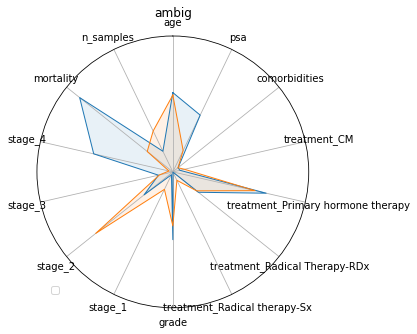

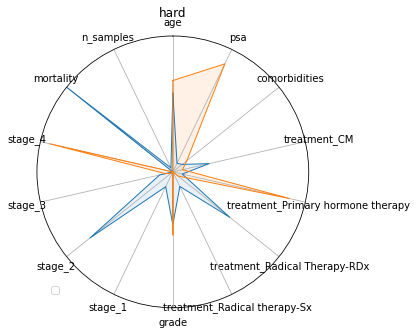

In [12]:
for subset in ["easy", "ambig", "hard"]:
    logging.info(f"Analyzing {subset}")

    if subset == "easy":
        embed = embedding_train_easy
        group = easy_train
    if subset == "ambig":
        embed = embedding_train_ambig
        group = ambig_train
    if subset == "hard":
        embed = embedding_train_hard
        group = hard_train

    sil_score = []

    if embed.shape[0] - 1 <= 10:
        n = 9
    else:
        n = 10
    for i in range(n):
        gm = GaussianMixture(n_components=i + 2, random_state=0).fit(embed)

        clusters = gm.predict(embed)
        sil_score.append(metrics.silhouette_score(embed, clusters, metric="euclidean"))

    best = 2  # for visualizing purposes - can be changed to min sil_score idx too

    gm = GaussianMixture(n_components=best, random_state=0).fit(embed)

    clusters = gm.predict(embed)

    unique_labels = np.unique(clusters)

    scaler = MinMaxScaler()
    cluster_dict = {}
    try:
        xdata = (X_train_pd - X_train_pd.min()) / (X_train_pd.max() - X_train_pd.min())
    except:
        xdata = X_train_pd
    mean_vals = np.mean(xdata.iloc[group, :])
    n_samples = len(xdata.iloc[group, :]) / len(xdata)

    for label in unique_labels:
        samples = np.where(clusters == unique_labels[label])[0]
        mean_vals = np.mean(xdata.iloc[group[samples], :])
        n_samples = len(xdata.iloc[group[samples], :]) / len(X_train_pd)
        cluster_dict[label] = mean_vals.append(
            pd.Series(
                [n_samples, np.mean(y_train[group[samples]])],
                index=["n_samples", "mortality"],
            )
        )
    pd.DataFrame(cluster_dict)

    cluster_df = pd.DataFrame(cluster_dict)

    groups = []
    for i in range(cluster_df.shape[1]):
        groups.append(i)
    group_dict = {"group": groups}

    for idx in list(cluster_df.index):
        group_dict[idx] = cluster_df.loc[[idx]].values[0]

    # Set data
    group_df = pd.DataFrame(group_dict)

    ######################################################################

    # RADIAL DIAGRAM

    ######################################################################
    # number of variables
    categories = list(group_df)[1:]
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    plt.figure(figsize=(5, 5))
    # Initialise the spider plot
    ax = plt.subplot(111, polar=True)

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels
    plt.xticks(angles[:-1], categories)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([10, 20, 30], ["10", "20", "30"], color="grey", size=7)
    plt.ylim(0, 1)

    for i in range(len(group_df)):
        values = group_df.loc[i].drop("group").values.flatten().tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=1, linestyle="solid")
        ax.fill(angles, values, alpha=0.1)

    # Add legend
    plt.legend(loc="upper right", bbox_to_anchor=(0.1, 0.1))
    plt.title(subset)
    plt.savefig(f"{dataset}_{subset}.svg", format="svg", dpi=1200)
    # Show the graph
    plt.show()